## Disclaimer: The training and testing data are not included in the submission file because it is too large to submit. Please include the promotion_classifier_data in the current directory before running the notebook.

# Setup

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus.common import thai_stopwords
from pythainlp.util import normalize
import emoji
import string
import cv2
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dropout, Dense, GlobalAveragePooling2D, Flatten, UpSampling2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
import efficientnet.tfkeras as efn

# Data Preparation

In [3]:
data_csv_path = os.path.join("promotion_classifier_data", "training_set.csv")
data = pd.read_csv(data_csv_path)

##### These are some functions that are used to clean and preprocess the data

In [4]:
def get_path(promotion_id, type_of_image):
    return os.path.join("promotion_classifier_data", type_of_image, promotion_id) + ".jpg"

def get_img(path_to_img):
    return mpimg.imread(path_to_img)

def resize_img(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

def remove_punctuation(text):
    text_without_punctuation = ""
    punctuations = []
    punctuations[:0] = string.punctuation
    
    for char in text:
        if not char in punctuations:
            text_without_punctuation += char
            
    return text_without_punctuation
            
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub("", text)

def remove_stopwords(list_of_description):
    tokenized_without_stopwords = []
    stopwords = list(thai_stopwords())
    for word in list_of_description:
        if not (word in stopwords or "\n" in word):
            tokenized_without_stopwords.append(word)
            
    return tokenized_without_stopwords

def transform_description(text):
    without_punctuation_description = remove_punctuation(text)
    normalized_description = normalize(without_punctuation_description)
    emojiless_description = remove_emoji(normalized_description)
    tokenized_description = word_tokenize(emojiless_description, keep_whitespace=False)
    without_stopwords_description = remove_stopwords(tokenized_description)
    
    return without_stopwords_description

def transform_img(promotion_id, type_of_image):
    path_to_img = get_path(promotion_id, type_of_image)
    img = get_img(path_to_img)
    resized_img = resize_img(img, (299, 299))
    
    return resized_img

def dataframe_pipeline(df, type_of_image):
    df = df.fillna("")
    df.loc[:, "tocount_description"] = df["description"].apply(word_tokenize)
    df.loc[:, "word_count"] = df["tocount_description"].apply(len)
    df.loc[:, "img_pixels"] = df["PromotionId"].apply(transform_img, type_of_image=type_of_image)
    
    return df

In [5]:
data = dataframe_pipeline(data, "training_images")

data.head(10)

,PromotionId,description,bad,tocount_description,word_count,img_pixels
0,1NWLAzBwCUadj2dLNYVrTib3XuTL0T,ซาลาปัง จัดใหญ่แทนใจคนที่คุณรัก,0,"[ซา, ลา, ปัง, , จัด, ใหญ่, แทน, ใจ, คน, ที่, ...",12,"[[[225, 226, 231], [225, 226, 231], [225, 226,..."
1,1NWLD3dp7tdq34WkgzQGLiPQM7dFC5,ทะเลทะลัก!! สุดยอดบุฟเฟ่ต์ทะเล ที่คุณไม่ควรพลา...,0,"[ทะเล, ทะลัก, !!, , สุดยอด, บุฟเฟ่ต์, ทะเล, ...",80,"[[[218, 159, 119], [233, 161, 123], [231, 147,..."
2,1NWLCHgnVeBb2TIup13b1RSOLOl3Cq,บัตรสมาชิก By อ.กุ้งเผาโคราช\n\n\n\nบัตรสมาชิก...,1,"[บัตรสมาชิก, , By, , อ., กุ้ง, เผา, โคราช, \...",160,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,1NWLC9rEila7y7EyYKPp17zCMkjHs2,สาวกเพื่อสุขภาพครับ,1,"[สาวก, เพื่อ, สุขภาพ, ครับ]",4,"[[[110, 84, 57], [98, 38, 28], [19, 13, 11], [..."
4,1NWLCUe1qEBZtZEwInmjdBoce8XBF2,วันเกิด แจ้งพนักงาน รับฟรีฮันนีโทส1จานค่ะ\n\n\n\n,0,"[วันเกิด, , แจ้ง, พนักงาน, , รับ, ฟรี, ฮันนี...",16,"[[[4, 4, 2], [6, 6, 4], [7, 7, 5], [7, 7, 5], ..."
5,1NWLC9g0nfGqwDLV0jzcb8Q6Ys3ZBT,ร้านน่ารัก ๆ,1,"[ร้าน, น่ารัก, , ๆ]",4,"[[[19, 21, 16], [79, 82, 75], [129, 132, 123],..."
6,1NWLAyIft6FUB8MT4aK0IKjLsaN70y,โปรโมชั่นวันเกิด แสดงบัตรประจำตัวประชาชนตรงกับ...,0,"[โปรโมชั่น, วันเกิด, , แสดง, บัตรประจำตัวประช...",22,"[[[252, 206, 69], [252, 206, 69], [252, 206, 6..."
7,1NWLBEnYhTJOdIuQCdW8RgVh5yXBDZ,ชานม,1,"[ชา, นม]",2,"[[[59, 55, 56], [59, 55, 56], [53, 49, 49], [4..."
8,1NWLDLTHIVeRaUZVvLobx8BeU4nrw1,ซื้อ 10 แก้ว ฟรี 1 แก้วค่ะ 😁,1,"[ซื้อ, , 10, , แก้ว, , ฟรี, , 1, , แก้ว, ...",14,"[[[202, 205, 214], [203, 206, 213], [204, 207,..."
9,1NWLCTNe0amJfILF8cozH9UUZEEmfR,สลัดเป็ด ซอสส้ม\n\n\n,1,"[สลัด, เป็ด, , ซอส, ส้ม, \n, \n, \n]",8,"[[[161, 150, 141], [140, 126, 111], [140, 124,..."


Created a histogram to visualize the word count in spam and non-spam descriptions. There seems to be some differences in word count between spam and non-spam descriptions so I decided to make word count as another feature to the machine learning model.

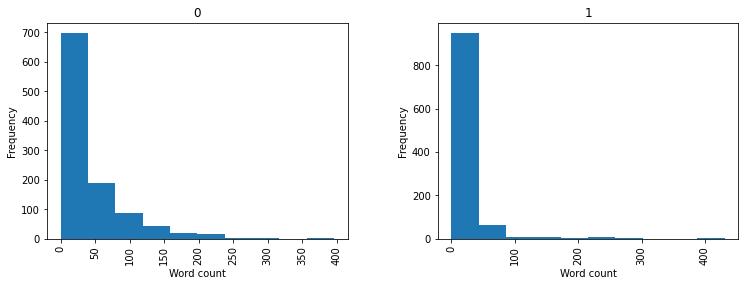

In [6]:
hist = data.hist(column="word_count", by="bad" ,figsize=(12,4), bins = 10)

for ax in hist.flatten():
    ax.set_xlabel("Word count")
    ax.set_ylabel("Frequency")

### Preprocess for Image data

The code below changes the image input into the shape that the deep learning model wants, which is (None, 299, 299, 3). The code below takes about 4-5 minutes to run.

In [7]:
img_input = data["img_pixels"][0].reshape(1, 299, 299, 3)
for idx, img in enumerate(data["img_pixels"].values):
    if idx != 0:
        img_input = np.concatenate((img_input, img.reshape(1, 299, 299, 3)))
    
# with open("img_input.npy", "wb") as f:
#     np.save(f, img_input)

# with open("img_input.npy", "rb") as f:
#     img_input = np.load(f)

Divided the data into a train, validation and test set with an 80% for training data and 10% each for validation and testing data.

In [8]:
X_img_train, X_img_test, y_img_train, y_img_test = train_test_split(img_input, data["bad"].values, train_size=0.8, random_state=35)
X_img_val, X_img_test, y_img_val, y_img_test = train_test_split(X_img_test, y_img_test, train_size=0.5, random_state=35)


I did some image augmentation so that we will have more data to train. However, the model's accuracy is better without these augmented images so I commented out the code.

In [9]:
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#   tf.keras.layers.RandomRotation(0.2),
# ])

# for idx in range(501):
#     for i in range(2):
#         augmented_image = data_augmentation(X_img_train[idx])
#         augmented_image = np.floor(augmented_image.numpy()).astype(int).reshape(1, 299, 299, 3)
#         X_img_train = np.concatenate((X_img_train, augmented_image), axis=0)
#         y_img_train = np.concatenate((y_img_train, np.array([y_img_train[idx]])), axis=0)

# with open("X_img_train.npy", "wb") as f:
#     np.save(f, X_img_train)

# with open("y_img_train.npy", "wb") as f:
#     np.save(f, y_img_train)
    
# with open("X_img_train.npy", "rb") as f:
#     X_img_train = np.load(f)
    
# with open("y_img_train.npy", "rb") as f:
#     y_img_train = np.load(f)

### Preprocess for description data

Transform the data using CountVectorizer and TfidfTransformer.

In [10]:
data_for_prediction = data.copy()
data = data.drop(labels=np.where(data["description"].apply(lambda x: x == ''))[0])

corpus = [x for x in data["description"].values]

description_pipe = Pipeline([
    ("vectorizer", CountVectorizer(analyzer = transform_description)),
    ("tfidf", TfidfTransformer())
])

X_tfidf = description_pipe.fit_transform(corpus)

Scales the word_count feature to have a mean of 0 and a standard deviation of 1.

In [11]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data["word_count"].values.reshape(-1, 1))
X_tfidf = np.concatenate((X_tfidf.toarray(), scaled), axis=1)

Divided the data into a train, validation and test set with an 80% for training data and 10% each for validation and testing data.

In [12]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_tfidf, data["bad"], train_size=0.8, random_state=35)
X_text_val, X_text_test, y_text_val, y_text_test = train_test_split(X_text_test, y_text_test, train_size=0.5, random_state=35)


# Building and Evaluating Models

### Support Vector Machine Model for training the description data

In [13]:
clf = SVC(kernel="linear", probability=True)
clf.fit(X_text_train, y_text_train)

SVC(kernel='linear', probability=True)

Create predictions for the validation data.

In [14]:
predictions = clf.predict(X_text_val)
predictions_proba = clf.predict_proba(X_text_val)
predictions_proba = np.max(predictions_proba, axis=1)

Classification report of the support vector machine model on the validation data.

In [15]:
print(classification_report(y_text_val, predictions))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        92
           1       0.83      0.79      0.81        61

    accuracy                           0.85       153
   macro avg       0.85      0.84      0.84       153
weighted avg       0.85      0.85      0.85       153



### Deep Learning Model for training the image data

I decided to use transfer learning because the data that I have is not a lot.

In [16]:
n_classes = 1
epochs = 25
batch_size = 64

height = 299
width = 299
channels = 3
input_shape = (height, width, channels)

In [17]:
efnb1 = efn.EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape, classes=n_classes)
efnb1.trainable = False

rescale = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255)
])

model = Sequential()
model.add(tf.keras.layers.Input(shape=(299, 299, 3)))
model.add(rescale)
model.add(efnb1)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(n_classes, activation='sigmoid'))

model.summary()

2022-01-03 20:54:54.444417: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 efficientnet-b1 (Functional  (None, 10, 10, 1280)     6575232   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)              

In [18]:
optimizer = Adam(0.001)

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)

model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

Save the deep learning model into a h5 file and loaded it into a variable named model.

In [19]:
# csv_logger = CSVLogger('training.log', separator=',', append=False)
# model_history = model.fit(x=X_img_train, y=y_img_train, validation_data = (X_img_val, y_img_val), callbacks = [early_stop, rlrop, csv_logger], verbose = 1, epochs = epochs, batch_size=batch_size)
# model.save("efficientnetb1_model.h5")
model = keras.models.load_model("efficientnetb1_model.h5")


Evaluation of the validation data.

In [20]:
val_loss, val_accuracy = model.evaluate(X_img_val, y_img_val, verbose=1, batch_size=batch_size)

/Users/mick/Desktop/thananun-kanchanachayphoom-assignment/spam-detection/vir/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


4/4 [==============================] - 15s 3s/step - loss: 0.4535 - accuracy: 0.7810


Visualization of the loss and accuracy of both the training and validation set.

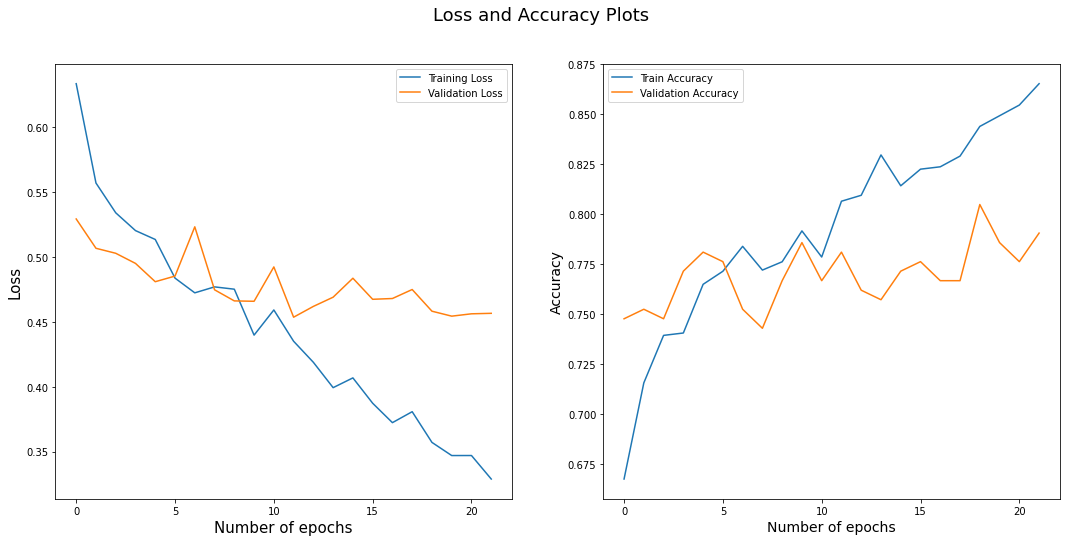

In [21]:
log_data = pd.read_csv('training.log', sep=',', engine='python')

plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(log_data['loss'], label='Training Loss')
plt.plot(log_data['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(log_data['accuracy'], label='Train Accuracy')
plt.plot(log_data['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

### Evaluation of validation data by combining both models

This is inspired by the ensemble methods which is combining machine learning models together to create a better model. In this case I am just looking at the output and see whether which model outputs a higher probability of being in a class and choose the output of that model.

In [22]:
corpus = [x for x in data_for_prediction["description"].values]
X_tfidf_predict = description_pipe.transform(corpus)
scaled_val = scaler.transform(data_for_prediction["word_count"].values.reshape(-1, 1))
X_tfidf_predict = np.concatenate((X_tfidf_predict.toarray(), scaled_val), axis=1)

X_text_predict_train, X_text_predict_test, y_text_predict_train, y_text_predict_test = train_test_split(X_tfidf_predict, data_for_prediction["bad"], train_size=0.8, random_state=35)
X_text_predict_val, X_text_predict_test, y_text_predict_val, y_text_predict_test = train_test_split(X_text_predict_test, y_text_predict_test, train_size=0.5, random_state=35)


Get predictions for the validation data

In [23]:
predictions_text_val = clf.predict(X_text_predict_val)
predictions_proba_text_val = clf.predict_proba(X_text_predict_val)
predictions_proba_text_val = np.max(predictions_proba_text_val, axis=1)

predictions_proba_img_val = model.predict(X_img_val) 
predictions_img_val = predictions_proba_img_val >= 0.5

In [24]:
def combine_predictions(predictions_img, predictions_proba_img, predictions_text, predictions_proba_text):
    predictions_img = predictions_img.astype(int)
    for i in range(len(predictions_proba_img)):
        if predictions_proba_img[i][0] <= 0.5:
            predictions_proba_img[i][0] = 1 - predictions_proba_img[i][0]
            
    final_predictions = []
    for i in range(len(predictions_text)):
        if predictions_proba_img[i][0] > predictions_proba_text[i]:
            final_predictions.append(predictions_img[i][0])
        else:
            final_predictions.append(predictions_text[i])
            
    return final_predictions

Classification report of the combined model on the validation data.

In [25]:
final_predictions_val = combine_predictions(predictions_img_val, predictions_proba_img_val, predictions_text_val, predictions_proba_text_val)

print(classification_report(y_img_val, final_predictions_val))


              precision    recall  f1-score   support

           0       0.94      0.93      0.93       107
           1       0.92      0.94      0.93       103

    accuracy                           0.93       210
   macro avg       0.93      0.93      0.93       210
weighted avg       0.93      0.93      0.93       210



### Evaluation of testing data by combining both models

Get predictions for the validation data

In [26]:
predictions_text_test = clf.predict(X_text_predict_test)
predictions_proba_text_test = clf.predict_proba(X_text_predict_test)
predictions_proba_text_test = np.max(predictions_proba_text_test, axis=1)

predictions_proba_img_test = model.predict(X_img_test) 
predictions_img_test = predictions_proba_img_test >= 0.5

In [27]:
final_predictions_test = combine_predictions(predictions_img_test, predictions_proba_img_test, predictions_text_test, predictions_proba_text_test)

print(classification_report(y_img_test, final_predictions_test))


              precision    recall  f1-score   support

           0       0.96      0.80      0.87       106
           1       0.83      0.96      0.89       105

    accuracy                           0.88       211
   macro avg       0.89      0.88      0.88       211
weighted avg       0.89      0.88      0.88       211



# Predicting future data

Load data into a dataframe and transform the dataframe.

In [28]:
test_data_csv_path = os.path.join("promotion_classifier_data", "testing_set.csv")
test_data = pd.read_csv(test_data_csv_path)
test_data = dataframe_pipeline(test_data, "testing_images")
test_data.head(10)

,PromotionId,description,tocount_description,word_count,img_pixels
0,1NWLA8yFGO4oZeRpAvdAY1JDJb6UtA,โปรโมชั่นพิเศษสำหรับ นักเรียน นักศึกษา เพียง แ...,"[โปรโมชั่น, พิเศษ, สำหรับ, , นักเรียน, , นัก...",19,"[[[51, 27, 23], [51, 27, 23], [51, 27, 23], [5..."
1,1NWLAsDec3ZqmKAKk8cOgDmg5dVwuQ,ส่วนลด 10 บาททันที สำหรับลูกค้าในการซื้อแก้วแรก,"[ส่วนลด, , 10, , บาท, ทันที, , สำหรับ, ลูกค...",14,"[[[191, 192, 197], [202, 202, 210], [216, 216,..."
2,1NWLAA6FbijUl5mqQ0Z2VTetfFlmRX,,[],0,"[[[166, 129, 79], [175, 138, 89], [176, 138, 8..."
3,1NWLCX8ML1e2c5pkgf8oT1AVfAsFio,LINEMAN บริการส่งเค้กถึงมือท่าน,"[LINEMAN, , บริการ, ส่ง, เค้ก, ถึง, มือ, ท่าน]",8,"[[[62, 128, 92], [62, 128, 92], [60, 125, 89],..."
4,1NWLC0j3XRIwoXpTNXFkZVah0bnasd,2 วันสุดท้ายของเดือนนี้\n\n\n30-31 สค 61,"[2, , วันสุดท้าย, ของ, เดือน, นี้, \n, \n, \n...",16,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
5,1NWLC7kLnFM4yOQYB03dlTzOD7mpfS,. Thousand Island Trio (เทาส์ซันไอแลนด์ทรี-โอ).,"[., , Thousand, , Island, , Trio, , (, เทา...",19,"[[[65, 46, 43], [47, 49, 63], [30, 52, 90], [1..."
6,1NWLCyOFSXLSEpd5pT0lhSL3CcyANR,วันนี้ที่ร้านมีต้มแซ่บเล้งขาหมูย่างด้วยน่ะ\n\n...,"[วันนี้, ที่, ร้าน, มี, ต้ม, แซ่บ, เล้ง, ขา, ห...",20,"[[[192, 173, 156], [192, 175, 157], [190, 175,..."
7,1NWLCdQ2XH3sSyKMJw17gJjwsZQ3hg,โปร มา4 จ่าย3 ถึง30 กันยายน 2561 นี้รีบๆชวนเพื...,"[โปร, , มา, 4, , จ่าย, 3, , ถึง, 30, , กัน...",24,"[[[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], ..."
8,1NWLCNO4PNXZkMj9bIizTckwvvf0w3,Craft Intersect 2nd Anniversary,"[Craft, , Intersect, , 2, nd, , Anniversary]",8,"[[[231, 195, 105], [250, 175, 42], [243, 180, ..."
9,1NWLC6LdQSm9qGmce4CnUFkpljQk1P,,[],0,"[[[165, 173, 176], [165, 173, 176], [167, 175,..."


Reshape the image input data into (None, 299, 299, 3).

In [29]:
img_input_test = test_data["img_pixels"][0].reshape(1, 299, 299, 3)
for idx, img in enumerate(test_data["img_pixels"].values):
    if idx != 0:
        img_input_test = np.concatenate((img_input_test, img.reshape(1, 299, 299, 3)))
    
# with open("img_input_test.npy", "wb") as f:
#     np.save(f, img_input_test)
    
# with open("img_input_test.npy", "rb") as f:
#     img_input_test = np.load(f)

Transform description data.

In [30]:
corpus = [x for x in test_data["description"].values]
X_tfidf_test = description_pipe.transform(corpus)
scaled_test = scaler.transform(test_data["word_count"].values.reshape(-1, 1))
X_tfidf_test = np.concatenate((X_tfidf_test.toarray(), scaled_test), axis=1)

Make predictions on both the image and description data.

In [31]:
predictions_text = clf.predict(X_tfidf_test)
predictions_proba_text = clf.predict_proba(X_tfidf_test)
predictions_proba_text = np.max(predictions_proba_text, axis=1)

predictions_proba_img = model.predict(img_input_test) 
predictions_img = predictions_proba_img >= 0.5

Combine both predictions and save the prediction into a csv file.

In [32]:
final_predictions = combine_predictions(predictions_img, predictions_proba_img, predictions_text, predictions_proba_text)

final_predictions_pd = pd.DataFrame({"bad": final_predictions})
final_predictions_pd.to_csv("prediction.csv")


# Future Improvement

In the future, I could create a class model that combines both the support vector machine model and the efficientnet B1 model. This class will make fitting, predicting and evaluating the model much more easier. I could also try more pre-trained architecture and fine-tuned the model more to try to increase the model's accuracy. The validation loss doesn't decrease as much and the validation accuracy doesn't increase as much and so I speculate that this could be due to some overfitting.